In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import importlib
import sys, os
sys.path.append("..")
import utils
import ampdlib
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
importlib.reload(utils)
fs = 50
#data_path = "../15_CombinedData/" # burst à 50hz toutes les 5 minutes pendant 800ms
#data_path = "../2024_08_Zypern200Hz/20240822_DataDL/"
data_path = "./data/"
test_file = "mergedsubs_4C_75_25_93_03_34_burstFormat_123464.csv"
#test_file = "mergedsubs_4C_75_25_93_05_10_burstFormat_123464.csv"
df_orig = pd.read_csv(os.path.join(data_path,test_file))
df = pd.read_csv(os.path.join(data_path,test_file))
long_bursts = utils.long_bursts(df,200) # keep only long bursts
df = utils.select_columns(long_bursts)
df_orig = utils.select_columns(df_orig)
df_orig = utils.concat_bursts(df_orig,fs=fs)
df_bursts = utils.concat_bursts(df,fs=fs)
df_bursts

,X,Y,Z,time,burst_idx
0,-0.124756,1.257568,-0.214844,2024-04-10 12:00:00+00:00,0
1,-0.079102,0.815674,-0.123779,2024-04-10 12:00:00.020000+00:00,0
2,-0.575195,1.347412,-0.289551,2024-04-10 12:00:00.040000+00:00,0
3,0.169189,0.167725,-0.366211,2024-04-10 12:00:00.060000+00:00,0
4,0.509766,0.822510,0.340332,2024-04-10 12:00:00.080000+00:00,0
...,...,...,...,...,...
441,-0.602051,0.643555,0.393555,2024-04-12 12:00:02.860000+00:00,2
442,-0.604004,0.642090,0.392090,2024-04-12 12:00:02.880000+00:00,2
443,-0.602783,0.642090,0.391113,2024-04-12 12:00:02.900000+00:00,2
444,-0.605713,0.644531,0.389404,2024-04-12 12:00:02.920000+00:00,2


Text(0.5, 1.0, 'Acceleration over Time')

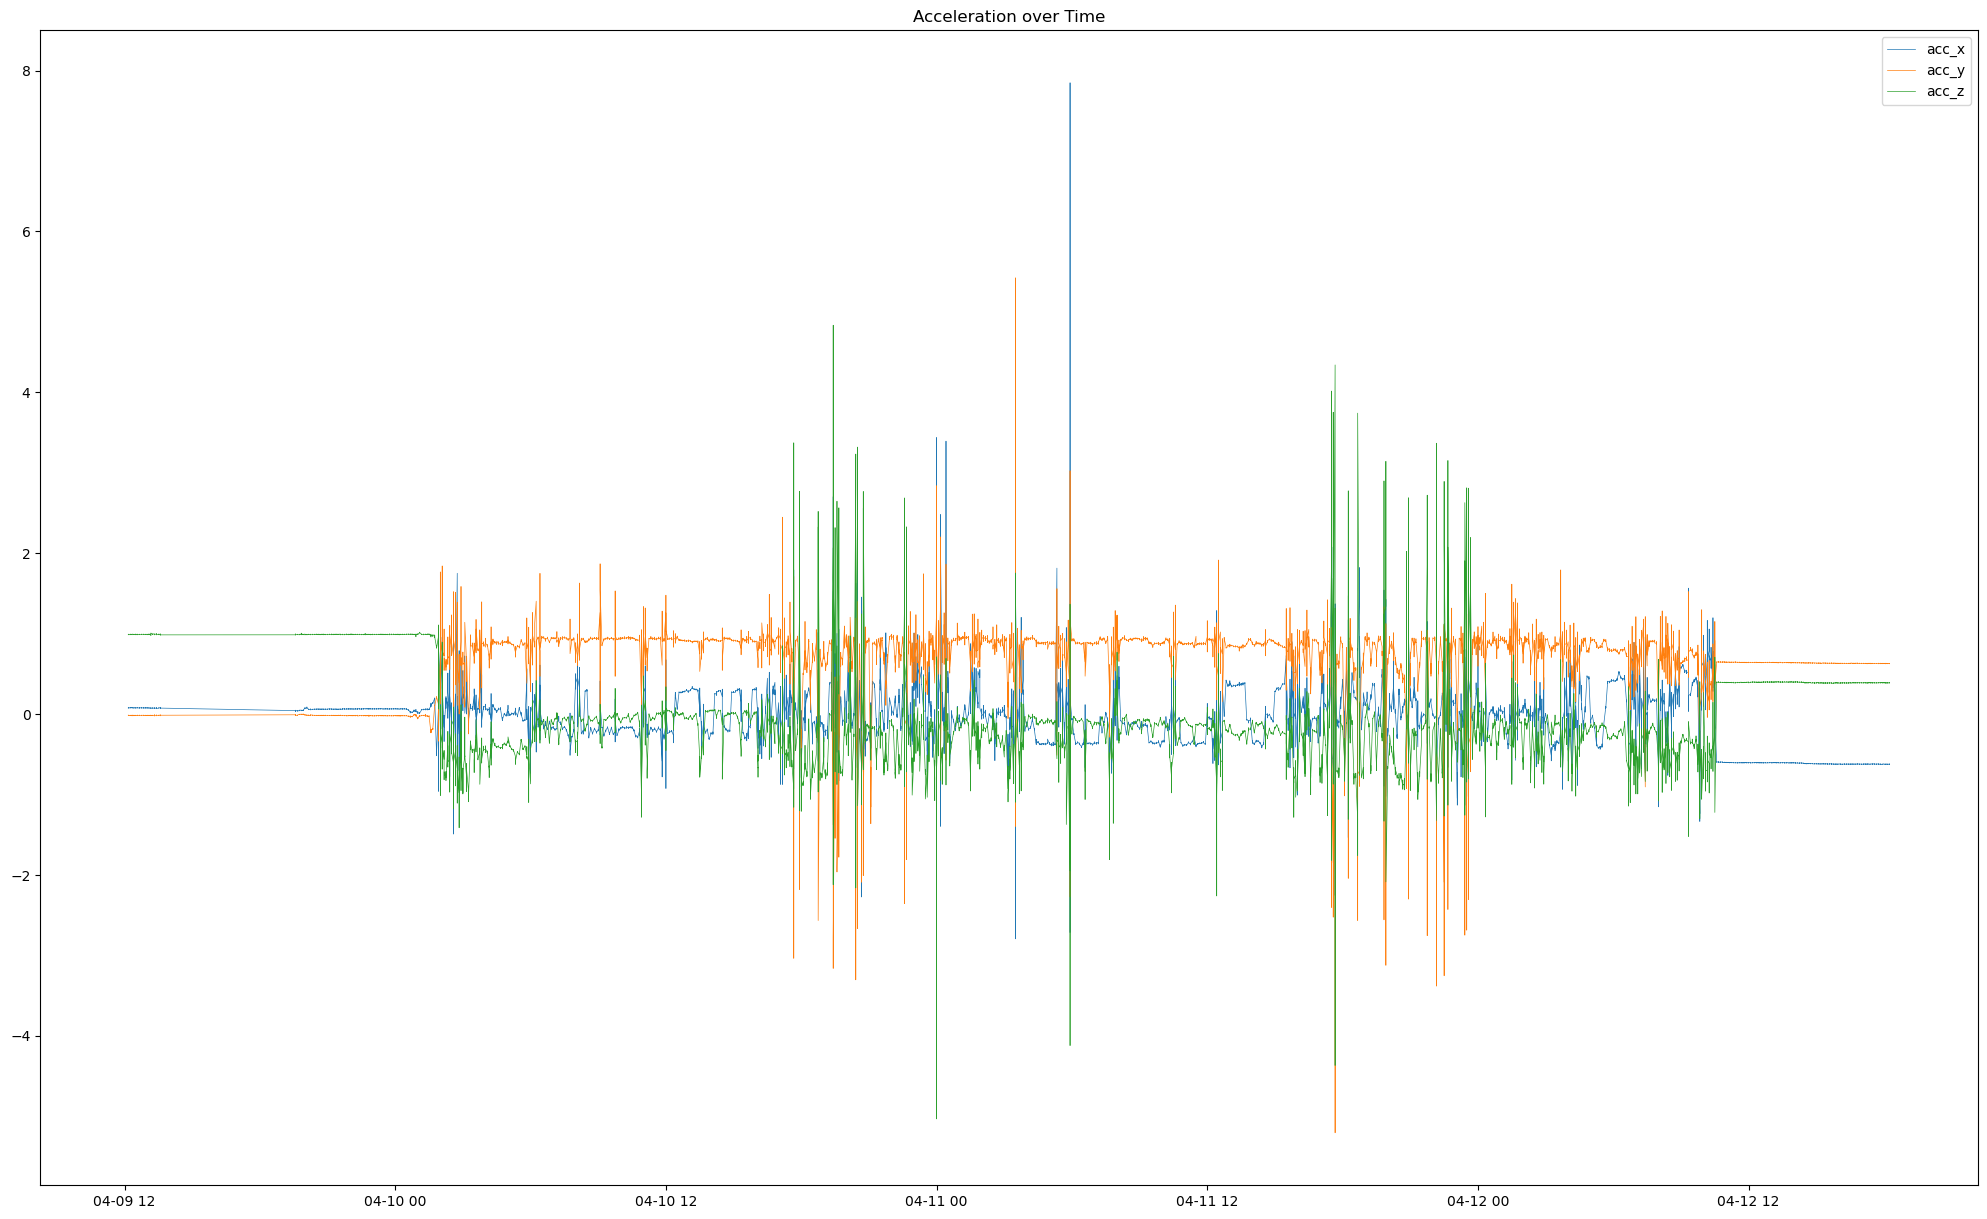

In [3]:
fig = plt.figure(figsize=(25, 15))
plt.plot(df_orig['time'], df_orig['X'], label='acc_x', linewidth=0.5)
plt.plot(df_orig['time'], df_orig['Y'], label='acc_y', linewidth=0.5)
plt.plot(df_orig['time'], df_orig['Z'], label='acc_z', linewidth=0.5)
plt.legend()
plt.title('Acceleration over Time')

In [4]:
importlib.reload(utils)
df_burst_i = df_bursts[df_bursts['burst_idx'] == 1]
accz = df_burst_i[['time', 'Z']].copy()
accz = accz.reset_index(drop=True)
sav_gol = savgol_filter(accz['Z'], 11, 8) # savitsky-golay
hf = accz['Z'] - sav_gol # remove to keep high frequencies
x = hf**2+1e-12 # shannon energy
see = -x * np.log(x)
accz["see"] = see
b, a = butter(4, 15/(fs/2), btype='low') # low pass to reduce noise (<15hz)
see_filt = filtfilt(b, a, see)
accz["see_filt"] = see_filt
peaks = ampdlib.ampd(accz["see_filt"].values) # AMPD
accz["is_peak"] = False
accz.loc[peaks, "is_peak"] = True
times = accz.loc[accz["is_peak"], "time"]
ibi = times.diff().dt.total_seconds().dropna()
hr = 60 / ibi
hr

15     428.571429
38     130.434783
49     272.727273
63     214.285714
78     200.000000
96     166.666667
105    333.333333
113    375.000000
134    142.857143
Name: time, dtype: float64

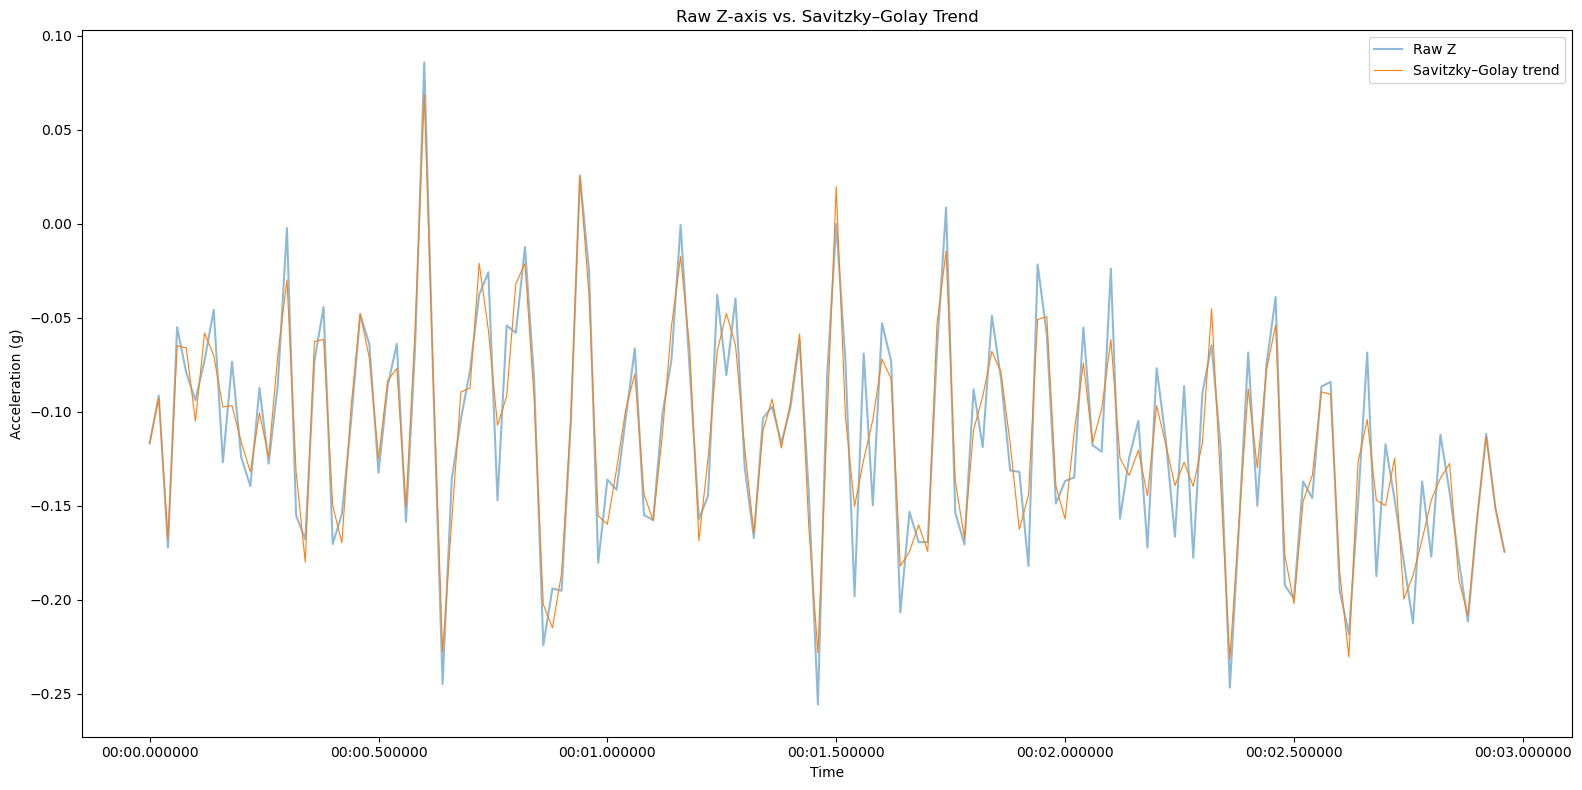

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(accz['time'], accz['Z'], label="Raw Z", alpha=0.5)
plt.plot(accz['time'], sav_gol, label="Savitzky–Golay trend", linewidth=0.8)
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title("Raw Z-axis vs. Savitzky–Golay Trend")
plt.legend()
plt.tight_layout()
plt.show()

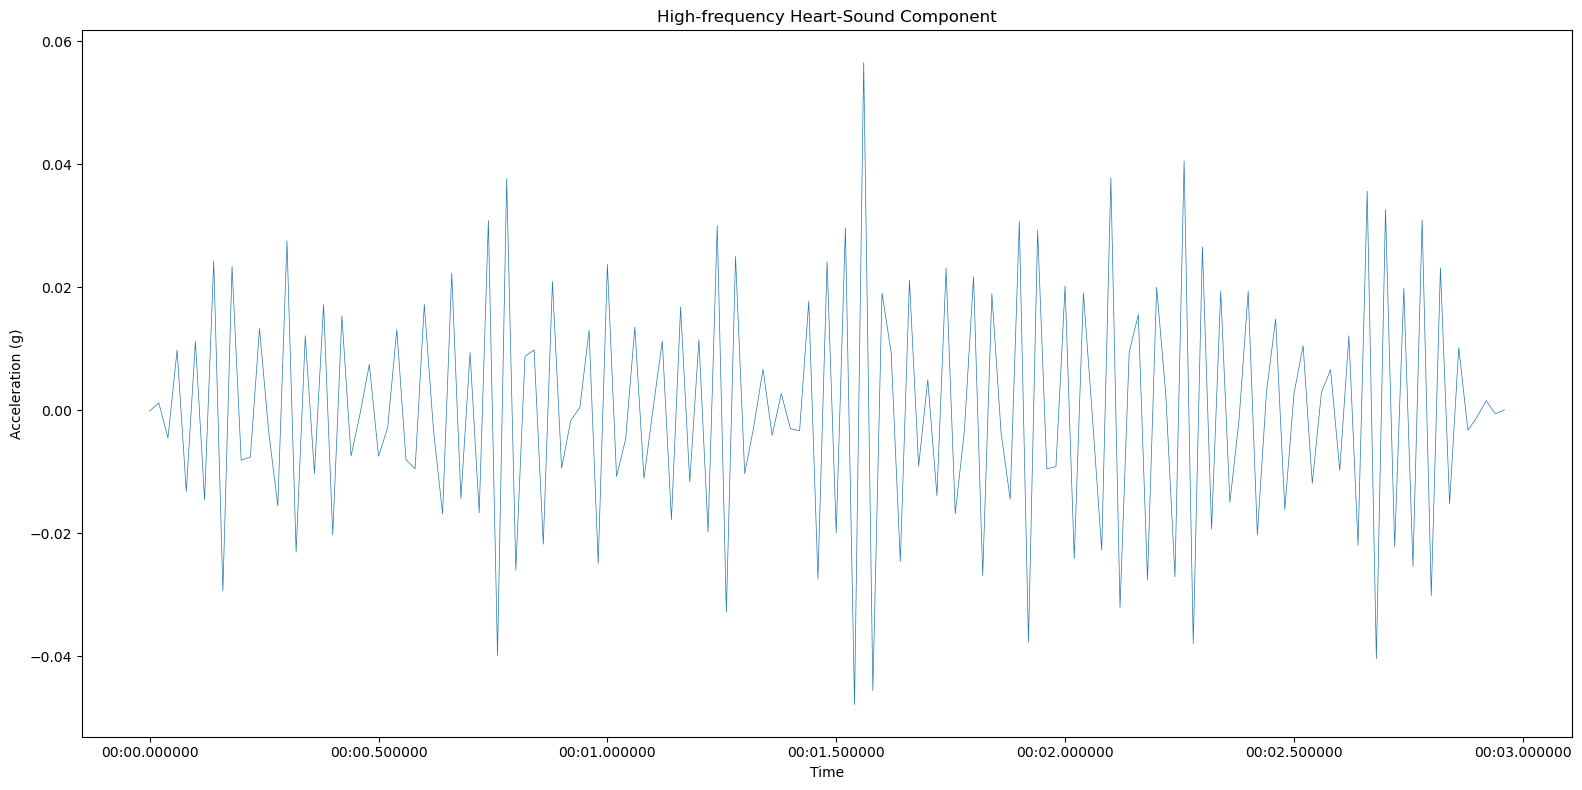

In [10]:
plt.figure(figsize=(16,8))
plt.plot(accz['time'], hf, label="High-frequency component (Z - SG)", linewidth=0.5)
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title("High-frequency Heart-Sound Component")
plt.tight_layout()
plt.show()

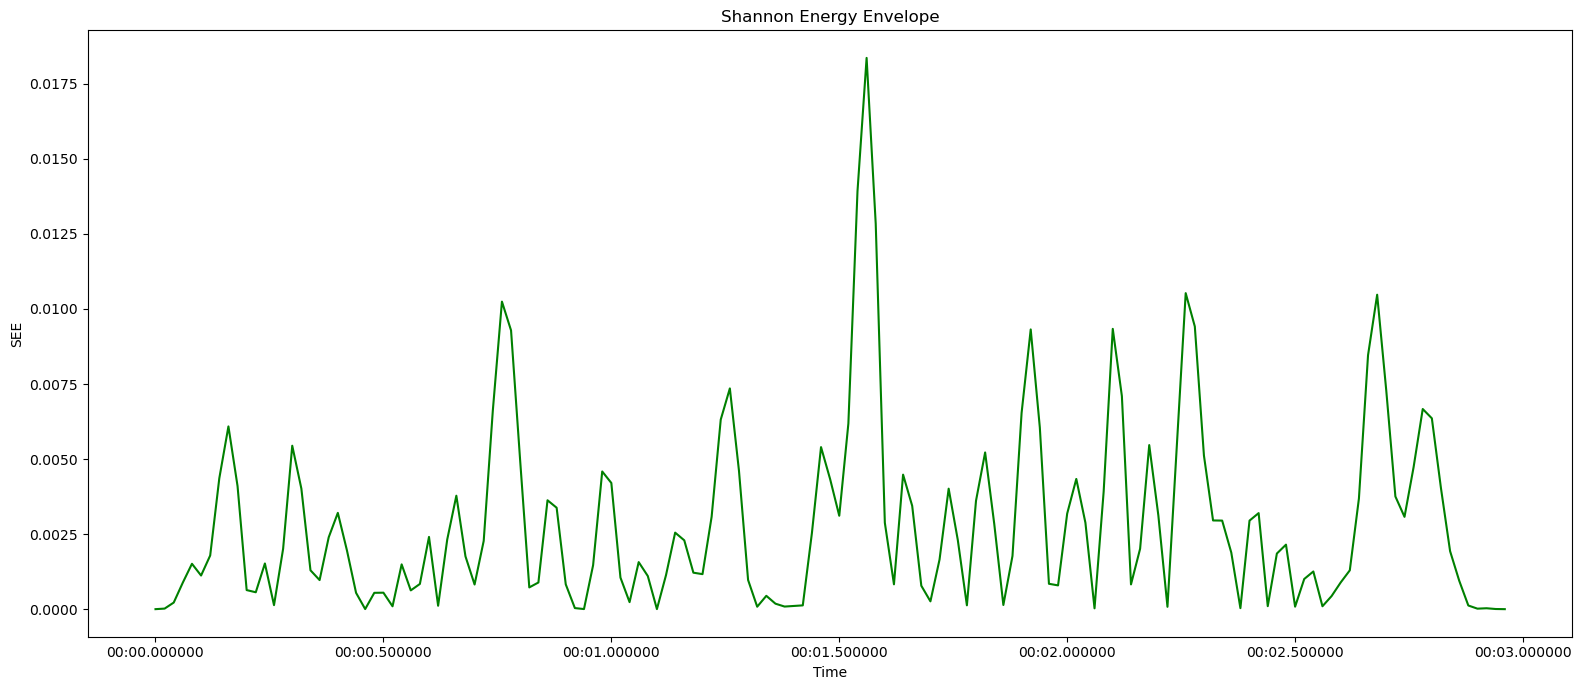

In [11]:
plt.figure(figsize=(16,7))
plt.plot(accz['time'], accz["see"], label="Shannon Energy Envelope", color="green")
plt.xlabel("Time")
plt.ylabel("SEE")
plt.title("Shannon Energy Envelope")
plt.tight_layout()
plt.show()

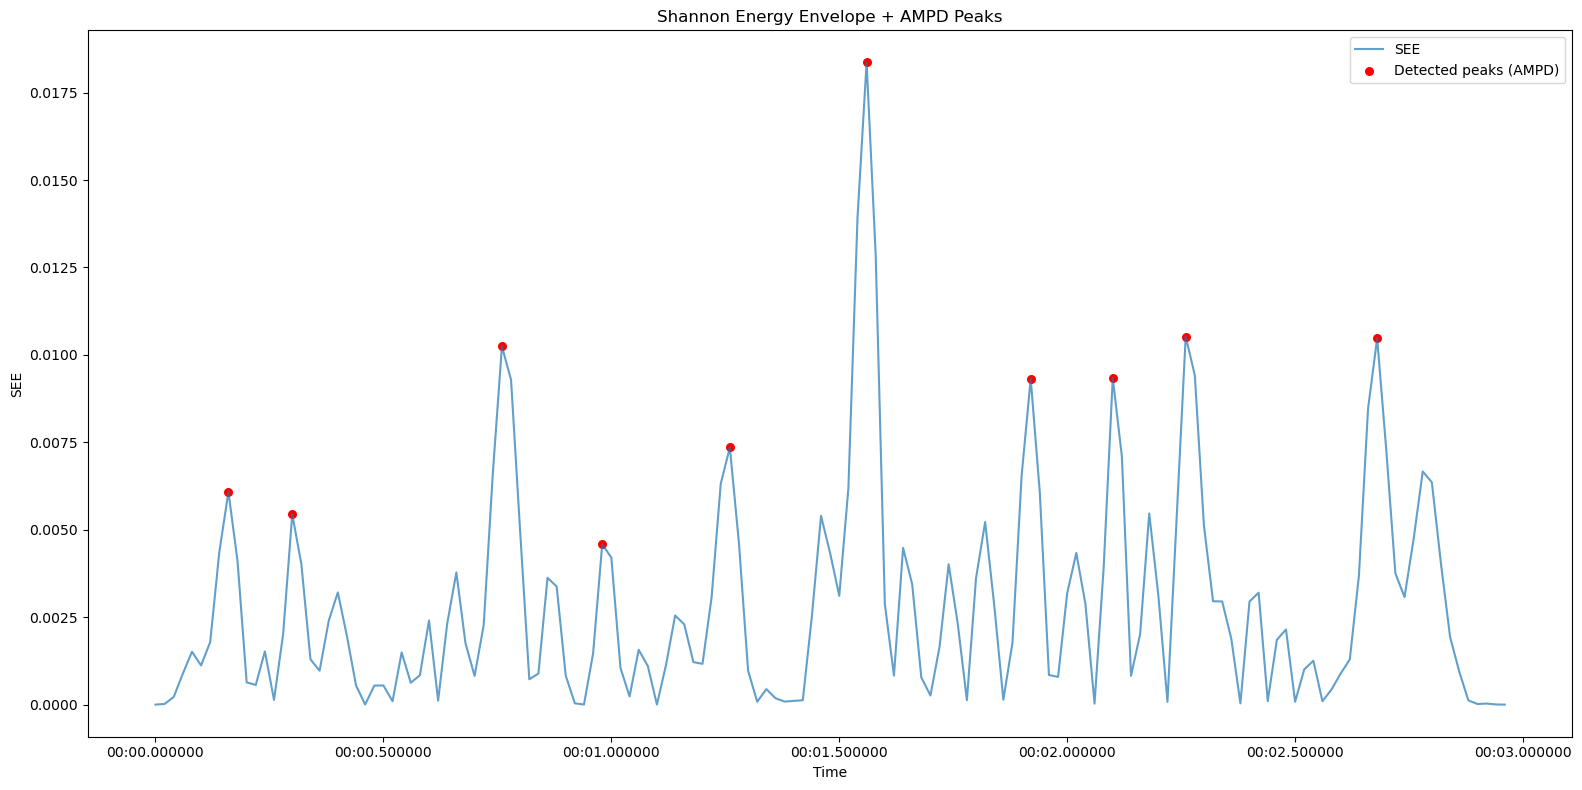

In [12]:
plt.figure(figsize=(16,8))
plt.plot(accz['time'], accz["see"], label="SEE", alpha=0.7)

# Mark peaks
plt.scatter(
    accz.loc[accz["is_peak"], "time"],
    accz.loc[accz["is_peak"], "see"],
    color="red",
    s=30,
    label="Detected peaks (AMPD)"
)

plt.xlabel("Time")
plt.ylabel("SEE")
plt.title("Shannon Energy Envelope + AMPD Peaks")
plt.legend()
plt.tight_layout()
plt.show()
